## Experimenting on classifying bot users via Random Forest Classifier

__Note__: The data in __support.json__ do not contain the __label__ attribute, so they were not used in this experiment.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix 

# For reproducible results
RANDOM_STATE_SEED = 420

### 1- Reading the data

In [2]:
def read_and_process_twibot_data(json_path):
    # Changing data types
    def change_df_dtypes(df):
        df["label"] = df["label"].astype("int8")
        df["profile.protected"] = df["profile.protected"].replace({"False": 0, "True": 1})
        df["profile.followers_count"] = df["profile.followers_count"].astype("int64")
        df["profile.friends_count"] =  df["profile.friends_count"].astype("int64")
        df["profile.listed_count"] = df["profile.listed_count"].astype("int64")
        df["profile.created_at"] = pd.to_numeric(pd.to_datetime(df["profile.created_at"]))
        df["profile.favourites_count"] = df["profile.favourites_count"].astype("int64")
        df["profile.geo_enabled"] = df["profile.geo_enabled"].replace({"False": 0, "True": 1})
        df["profile.verified"] = df["profile.verified"].replace({"False": 0, "True": 1})
        df["profile.statuses_count"] = df["profile.statuses_count"].astype("int64")
        df["profile.contributors_enabled"] = df["profile.contributors_enabled"].replace({"False": 0, "True": 1})
        df["profile.is_translator"] = df["profile.is_translator"].replace({"False": 0, "True": 1})
        df["profile.is_translation_enabled"] = df["profile.is_translation_enabled"].replace({"False": 0, "True": 1})
        df["profile.profile_use_background_image"] = df["profile.profile_use_background_image"].replace({"False": 0, "True": 1})
        df["profile.has_extended_profile"] = df["profile.has_extended_profile"].replace({"False": 0, "True": 1})
        df["profile.default_profile"] = df["profile.default_profile"].replace({"False": 0, "True": 1})
        df["profile.default_profile_image"] = df["profile.default_profile_image"].replace({"False": 0, "True": 1})

        return df
    
    # Reading nested Json reference:
    #  https://towardsdatascience.com/how-to-convert-json-into-a-pandas-dataframe-100b2ae1e0d8
    with open(json_path, "r") as f:
        data = json.loads(f.read())

    df = pd.json_normalize(data=data)
    
    # Dropping columns
    columns_to_drop = [
        "ID",
        "tweet",
        "neighbor",
        "domain",
        "profile.id",
        "profile.id_str",
        "profile.name",
        "profile.screen_name",
        "profile.location",
        "profile.profile_location",
        "profile.description",
        "profile.url",
        "profile.entities",
        "profile.utc_offset",
        "profile.time_zone",
        "profile.lang",
        "profile.profile_background_color",
        "profile.profile_background_image_url",
        "profile.profile_background_image_url_https",
        "profile.profile_background_tile",
        "profile.profile_image_url",
        "profile.profile_image_url_https",
        "profile.profile_link_color",
        "profile.profile_sidebar_border_color",
        "profile.profile_sidebar_fill_color",
        "profile.profile_text_color",
        "neighbor.following",
        "neighbor.follower"
    ]
    
    df.drop(columns=columns_to_drop, axis=1, inplace=True)
    
    # Removing extra whitespace from "profile" attributes
    extra_whitespace_cols = [
        "profile.protected",
        "profile.followers_count",
        "profile.friends_count",
        "profile.listed_count",
        "profile.created_at",
        "profile.favourites_count",
        "profile.geo_enabled",
        "profile.verified",
        "profile.statuses_count",
        "profile.contributors_enabled",
        "profile.is_translator",
        "profile.is_translation_enabled",
        "profile.profile_use_background_image",
        "profile.has_extended_profile",
        "profile.default_profile",
        "profile.default_profile_image"
    ]
    
    for col in extra_whitespace_cols:
        df[col] = df[col].str.strip()
    
    df = change_df_dtypes(df)
    
    # MinMax scaling of numerical columns
    numerical_cols = [
        "profile.followers_count",
        "profile.friends_count",
        "profile.listed_count",
        "profile.created_at",
        "profile.favourites_count",
        "profile.statuses_count"
    ]
    
    df[numerical_cols] = MinMaxScaler().fit_transform(df[numerical_cols])
    
    return df
    

In [3]:
train_df = read_and_process_twibot_data("data/Twibot-20/train.json")
train_df

,label,profile.protected,profile.followers_count,profile.friends_count,profile.listed_count,profile.created_at,profile.favourites_count,profile.geo_enabled,profile.verified,profile.statuses_count,profile.contributors_enabled,profile.is_translator,profile.is_translation_enabled,profile.profile_use_background_image,profile.has_extended_profile,profile.default_profile,profile.default_profile_image
0,0,0,1.365584e-01,0.000159,0.082824,0.184182,0.000181,1,1,0.001906,0,0,0,1,0,0,0
1,1,0,0.000000e+00,0.000010,0.000000,0.997725,0.000009,0,0,0.000000,0,0,0,1,1,1,0
2,0,0,6.786633e-03,0.000109,0.005818,0.185952,0.001216,1,1,0.001074,0,0,0,0,0,0,0
3,0,0,2.914393e-03,0.001106,0.003170,0.164524,0.003760,1,1,0.037524,0,0,0,1,0,0,0
4,1,0,1.185376e-04,0.000149,0.000080,0.510992,0.000930,0,0,0.000020,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8273,0,0,9.783533e-05,0.000189,0.000402,0.508833,0.025675,0,1,0.005017,0,0,0,1,0,1,0
8274,1,0,3.914481e-07,0.000147,0.000000,0.692580,0.000380,0,0,0.000083,0,0,0,1,0,1,0
8275,1,0,3.042619e-06,0.000196,0.000000,0.255361,0.003145,0,0,0.000280,0,0,0,1,1,1,0
8276,1,0,6.405514e-07,0.000085,0.000004,0.516382,0.003362,0,0,0.000131,0,0,0,1,0,1,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8278 entries, 0 to 8277
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   label                                 8278 non-null   int8   
 1   profile.protected                     8278 non-null   int64  
 2   profile.followers_count               8278 non-null   float64
 3   profile.friends_count                 8278 non-null   float64
 4   profile.listed_count                  8278 non-null   float64
 5   profile.created_at                    8278 non-null   float64
 6   profile.favourites_count              8278 non-null   float64
 7   profile.geo_enabled                   8278 non-null   int64  
 8   profile.verified                      8278 non-null   int64  
 9   profile.statuses_count                8278 non-null   float64
 10  profile.contributors_enabled          8278 non-null   int64  
 11  profile.is_transl

In [5]:
dev_df = read_and_process_twibot_data("data/Twibot-20/dev.json")
dev_df

,label,profile.protected,profile.followers_count,profile.friends_count,profile.listed_count,profile.created_at,profile.favourites_count,profile.geo_enabled,profile.verified,profile.statuses_count,profile.contributors_enabled,profile.is_translator,profile.is_translation_enabled,profile.profile_use_background_image,profile.has_extended_profile,profile.default_profile,profile.default_profile_image
0,0,0,1.116343e-06,0.000588,0.000000,0.958815,0.000768,0,0,0.000059,0,0,0,1,0,1,0
1,1,0,1.645786e-05,0.003140,0.000054,0.426977,0.002819,0,0,0.002259,0,0,0,1,1,1,0
2,0,0,1.440567e-03,0.005469,0.004243,0.248038,0.064501,1,1,0.021937,0,0,0,0,0,0,0
3,1,0,2.528041e-03,0.023234,0.010931,0.091322,0.000071,0,0,0.014572,0,0,0,1,0,0,0
4,0,0,2.031265e-02,0.160070,0.077858,0.164183,0.002395,1,1,0.179265,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2360,1,0,3.273513e-05,0.000287,0.000149,0.389554,0.004170,1,0,0.001548,0,0,0,0,1,0,0
2361,1,0,1.231261e-06,0.000436,0.000005,0.904346,0.000367,0,0,0.000091,0,0,0,1,1,1,0
2362,1,0,3.600125e-04,0.030312,0.005301,0.247241,0.073181,0,0,0.139314,0,0,0,1,1,1,0
2363,0,0,2.298354e-07,0.000070,0.000000,0.445125,0.000260,0,0,0.000008,0,0,0,1,0,1,0


In [6]:
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2365 entries, 0 to 2364
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   label                                 2365 non-null   int8   
 1   profile.protected                     2365 non-null   int64  
 2   profile.followers_count               2365 non-null   float64
 3   profile.friends_count                 2365 non-null   float64
 4   profile.listed_count                  2365 non-null   float64
 5   profile.created_at                    2365 non-null   float64
 6   profile.favourites_count              2365 non-null   float64
 7   profile.geo_enabled                   2365 non-null   int64  
 8   profile.verified                      2365 non-null   int64  
 9   profile.statuses_count                2365 non-null   float64
 10  profile.contributors_enabled          2365 non-null   int64  
 11  profile.is_transl

In [7]:
test_df = read_and_process_twibot_data("data/Twibot-20/test.json")
test_df

,label,profile.protected,profile.followers_count,profile.friends_count,profile.listed_count,profile.created_at,profile.favourites_count,profile.geo_enabled,profile.verified,profile.statuses_count,profile.contributors_enabled,profile.is_translator,profile.is_translation_enabled,profile.profile_use_background_image,profile.has_extended_profile,profile.default_profile,profile.default_profile_image
0,1,0,1.900731e-04,0.021061,0.000008,0.937419,0.132461,0,0,0.057870,0,0,0,1,1,1,0
1,0,0,1.000000e+00,0.000062,0.705426,0.248942,0.000006,1,1,0.004151,0,0,1,1,0,0,0
2,0,0,1.853396e-03,0.000449,0.012397,0.244743,0.002365,0,1,0.085817,0,0,0,1,0,0,0
3,1,0,1.030765e-07,0.000675,0.000000,0.997052,0.000000,0,0,0.000002,0,0,0,1,1,1,0
4,0,0,3.265580e-01,0.001052,0.338339,0.456113,0.003485,0,1,0.013893,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,1,0,8.887488e-05,0.010073,0.000893,0.362884,0.000233,0,0,0.002710,0,0,0,1,0,0,0
1179,1,0,9.673160e-05,0.000507,0.000464,0.749600,0.390472,0,0,0.058348,0,0,0,1,0,1,0
1180,1,0,3.538961e-06,0.002437,0.000025,0.501325,0.004878,1,0,0.003431,0,0,0,0,1,0,0
1181,1,0,1.763754e-06,0.001267,0.000000,0.426047,0.001946,0,0,0.000177,0,0,0,1,0,1,0


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1183 entries, 0 to 1182
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   label                                 1183 non-null   int8   
 1   profile.protected                     1183 non-null   int64  
 2   profile.followers_count               1183 non-null   float64
 3   profile.friends_count                 1183 non-null   float64
 4   profile.listed_count                  1183 non-null   float64
 5   profile.created_at                    1183 non-null   float64
 6   profile.favourites_count              1183 non-null   float64
 7   profile.geo_enabled                   1183 non-null   int64  
 8   profile.verified                      1183 non-null   int64  
 9   profile.statuses_count                1183 non-null   float64
 10  profile.contributors_enabled          1183 non-null   int64  
 11  profile.is_transl

### 2- Combining the train and dev datasets

In [9]:
train_df = pd.concat([train_df, dev_df], ignore_index=True)

In [10]:
train_df

,label,profile.protected,profile.followers_count,profile.friends_count,profile.listed_count,profile.created_at,profile.favourites_count,profile.geo_enabled,profile.verified,profile.statuses_count,profile.contributors_enabled,profile.is_translator,profile.is_translation_enabled,profile.profile_use_background_image,profile.has_extended_profile,profile.default_profile,profile.default_profile_image
0,0,0,1.365584e-01,0.000159,0.082824,0.184182,0.000181,1,1,0.001906,0,0,0,1,0,0,0
1,1,0,0.000000e+00,0.000010,0.000000,0.997725,0.000009,0,0,0.000000,0,0,0,1,1,1,0
2,0,0,6.786633e-03,0.000109,0.005818,0.185952,0.001216,1,1,0.001074,0,0,0,0,0,0,0
3,0,0,2.914393e-03,0.001106,0.003170,0.164524,0.003760,1,1,0.037524,0,0,0,1,0,0,0
4,1,0,1.185376e-04,0.000149,0.000080,0.510992,0.000930,0,0,0.000020,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10638,1,0,3.273513e-05,0.000287,0.000149,0.389554,0.004170,1,0,0.001548,0,0,0,0,1,0,0
10639,1,0,1.231261e-06,0.000436,0.000005,0.904346,0.000367,0,0,0.000091,0,0,0,1,1,1,0
10640,1,0,3.600125e-04,0.030312,0.005301,0.247241,0.073181,0,0,0.139314,0,0,0,1,1,1,0
10641,0,0,2.298354e-07,0.000070,0.000000,0.445125,0.000260,0,0,0.000008,0,0,0,1,0,1,0


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10643 entries, 0 to 10642
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   label                                 10643 non-null  int8   
 1   profile.protected                     10643 non-null  int64  
 2   profile.followers_count               10643 non-null  float64
 3   profile.friends_count                 10643 non-null  float64
 4   profile.listed_count                  10643 non-null  float64
 5   profile.created_at                    10643 non-null  float64
 6   profile.favourites_count              10643 non-null  float64
 7   profile.geo_enabled                   10643 non-null  int64  
 8   profile.verified                      10643 non-null  int64  
 9   profile.statuses_count                10643 non-null  float64
 10  profile.contributors_enabled          10643 non-null  int64  
 11  profile.is_tran

### 3- Checking label distribution

In [12]:
train_df["label"].value_counts()

1    5949
0    4694
Name: label, dtype: int64

In [13]:
train_df["label"].value_counts()[1]

5949

In [14]:
# Percentage of "bot" accounts
train_df["label"].value_counts()[1] / train_df.shape[0]

0.5589589401484544

In [15]:
test_df["label"].value_counts()

1    640
0    543
Name: label, dtype: int64

In [16]:
test_df["label"].value_counts()[1] / test_df.shape[0]

0.5409974640743872

### 4- Preparing the data for Random Forest Classifier training

In [17]:
y_train = np.array(train_df.pop("label")) # pop removes "label" from the dataframe
X_train = train_df.values

print(type(X_train))
print(type(y_train))
print(X_train.shape)
print(y_train.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(10643, 16)
(10643,)


In [18]:
y_test = np.array(test_df.pop("label")) # pop removes "label" from the dataframe
X_test = test_df.values

print(type(X_test))
print(type(y_test))
print(X_test.shape)
print(y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1183, 16)
(1183,)


### 5- Training Random Forest Classifier

In [19]:
model = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None
)

hyperparameters = {
    'n_estimators': [i for i in range(100, 1000, 100)]
}

In [20]:
clf = GridSearchCV(
    estimator=model,
    param_grid=hyperparameters,
    cv=5,
    verbose=1,
    n_jobs=-1  # Use all available CPU cores
)

In [21]:
clf.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                          800, 900]},
             verbose=1)

### 6- Extracting best performing model in the 5-fold cross-validation Grid Search

In [22]:
print("Accuracy score on Validation set: \n")
print(clf.best_score_ )
print("---------------")
print("Best performing hyperparameters on Validation set: ")
print(clf.best_params_)
print("---------------")
print(clf.best_estimator_)

Accuracy score on Validation set: 

0.802587213100859
---------------
Best performing hyperparameters on Validation set: 
{'n_estimators': 800}
---------------
RandomForestClassifier(n_estimators=800)


In [23]:
model = clf.best_estimator_

In [24]:
model

RandomForestClassifier(n_estimators=800)

### 7- Evaluating on Test set

In [25]:
predictions = model.predict(X_test)

In [26]:
predictions

array([1, 0, 0, ..., 1, 1, 1], dtype=int8)

#### 7.1- Accuracy on Test set 

In [27]:
print(accuracy_score(y_test, predictions))

0.8106508875739645


#### 7.2- Confusion matrix

In [28]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[341 202]
 [ 22 618]]


/home/tamer/anaconda3/envs/twibot-20/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


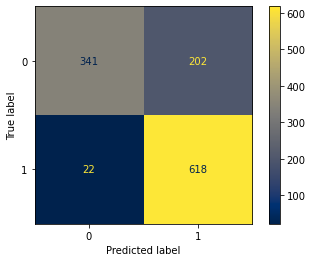

In [29]:
plot_confusion_matrix(model, X_test, y_test, cmap="cividis")

#### 7.3- Classification report

In [30]:
print(classification_report(y_test, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.93939   0.62799   0.75276       543
           1    0.75366   0.96562   0.84658       640

    accuracy                        0.81065      1183
   macro avg    0.84653   0.79681   0.79967      1183
weighted avg    0.83891   0.81065   0.80351      1183



### 8- Saving Model

In [31]:
joblib.dump(model, "trained_models/random-forest-classifier.pkl")

['trained_models/random-forest-classifier.pkl']

### 9- Testing loading model

In [32]:
model = joblib.load("trained_models/random-forest-classifier.pkl")

In [33]:
model

RandomForestClassifier(n_estimators=800)